In [ ]:
from pathlib import Path

import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_12669/1937271613.py:3: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("all_dyads.csv")


In [2]:
import xgboost as xgb

df["therapy_length_days"] = (
    pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
).dt.days
df["medication_length_days"] = (
    pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Medication start date"])
).dt.days

# Select features
X = df.drop(
    [
        "tantrum_within_60m",
        "tantrum_within_15m",
        "tantrum_within_30m",
        "tantrum_within_45m",
        "DurationInSeconds",  # total active time
        "ActivityDateTime",
        "SleepMorningDate",
        "Arm",
        "Diagnosis",
        "CDI start date",
        "PDI start date",
        "PDI end date",
        # "Medication ",
        "Type of medication",
        "Medication start date",
        "Week",
        "Therapy session",
        "Therapy Start",
        "Therapy End",
        "Education Status",
        "Parental Status",
        "Pre.ECBI",
        "Pre.ECBI.Prob",
        "Post.ECBI",
        "Post.ECBI.Prob",
        "dyad",
        "QuitStudy",
        "Employment Status",
        "ParticipatingParent.Sex",
        "Parent-PhoneType",
        # "Parent.Married",
        # "Parent.Age",
        # "BothParentsInStudy",
        # "Parent.WidowedSingle",
        # "Parent.SeparatedDivorced",
        # "Parent.Engaged.Together",
        # "Child.On.Stimulants",
        # "Child.On.Non.Stimulants",
    ]
    # moving window stats
    + [
        "hr_moving_avg_15m",
        "hr_moving_std_15m",
        "hr_moving_min_15m",
        "hr_moving_max_15m",
        "hr_moving_avg_30m",
        "hr_moving_std_30m",
        "hr_moving_min_30m",
        "hr_moving_max_30m",
        "hr_moving_avg_45m",
        "hr_moving_std_45m",
        "hr_moving_min_45m",
        "hr_moving_max_45m",
    ],
    axis=1,
)
X = X.drop([col for col in X.columns if col.startswith("hr-prev")], axis=1)


def yn_to_bool(df):
    """
    Convert columns with 'Y'/'N' strings to boolean True/False.
    """
    for col in df.columns:
        if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
            df[col] = df[col].map({"Y": True, "N": False})
    return df


X = yn_to_bool(X)

# Convert categorical columns to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Target variable
y = df["tantrum_within_30m"].astype(int)

# # Predictions every 30 min
# X = X.iloc[::2].reset_index(drop=True)
# y = y.iloc[::2].reset_index(drop=True)

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_12669/2842322121.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [3]:
from numpy import mean, std
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_validate,
)


def evaluate_model(model, X, y) -> None:
    # 1) Stratified K-folds maintains the distribution of positive and negative samples in each fold,
    # which is important for imbalanced datasets.
    # 2) Repeating lowers variance by repeating the cross-validation process multiple times.
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    scores = cross_validate(
        model,
        X,
        y,
        scoring=["f1", "recall", "precision"],
        cv=cv,
        n_jobs=-1,
    )

    # summarize performance
    print(f"F1: {mean(scores['test_f1']):.5f} +/- {std(scores['test_f1']):.5f}")
    print(
        f"Precision: {mean(scores['test_precision']):.5f} +/- {std(scores['test_precision']):.5f}"
    )
    print(
        f"Recall: {mean(scores['test_recall']):.5f} +/- {std(scores['test_recall']):.5f}"
    )

In [4]:
from sklearn.base import BaseEstimator


class SimpleModel(BaseEstimator):
    def __init__(self, threshold: int):
        self.threshold = threshold

    def fit(self, X, y):
        return self

    def predict(self, X):
        mean_hr = X["hr_moving_avg_60m"]
        return (mean_hr > 105) & (mean_hr < 129)

In [5]:
model = SimpleModel(threshold=100)
evaluate_model(model, X, y)

F1: 0.00806 +/- 0.00069
Precision: 0.00407 +/- 0.00035
Recall: 0.36271 +/- 0.03061


In [6]:
# Train XGBoost classifier
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"Scale pos weight: {scale_pos_weight}")
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

evaluate_model(model, X, y)

Scale pos weight: 390.07666941467437


/Users/zhu.henian/projects/pistachio/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


F1: 0.08135 +/- 0.00724
Precision: 0.04361 +/- 0.00401
Recall: 0.60756 +/- 0.04292


Baseline AUC-PR: 0.0026


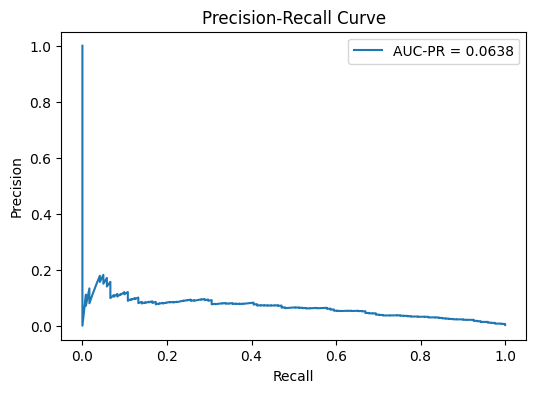

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Baseline AUC-PR: {1 / scale_pos_weight:.4f}")
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

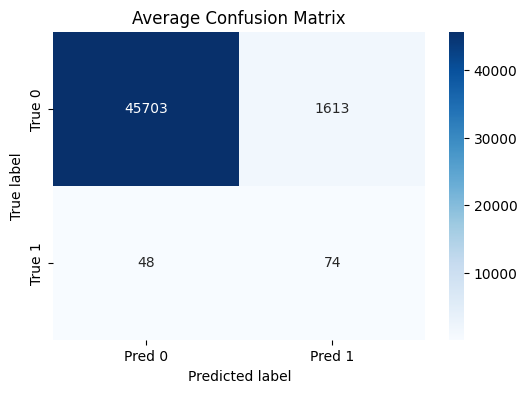

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

conf_matrices = []
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

# Average confusion matrix over all folds
avg_conf_matrix = sum(conf_matrices) / len(conf_matrices)

plt.figure(figsize=(6, 4))
sns.heatmap(
    avg_conf_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"],
)
plt.title("Average Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [9]:
import shap

# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
# Fit the model if not already fitted
model.fit(X, y)

# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X)

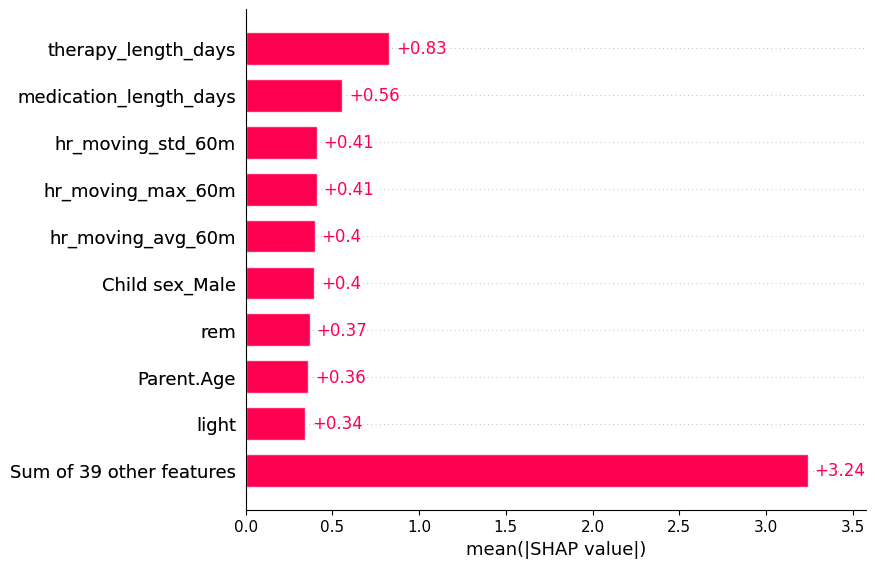

In [10]:
# Mean shap values
shap.plots.bar(shap_values)

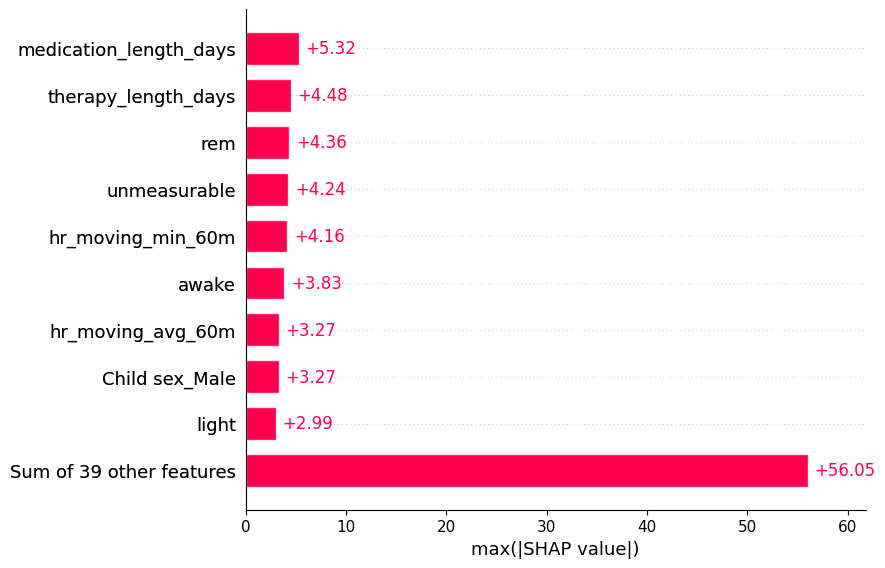

In [11]:
# Absolute max value highlights features that have infrequent but strong impacts
shap.plots.bar(shap_values.abs.max(0))

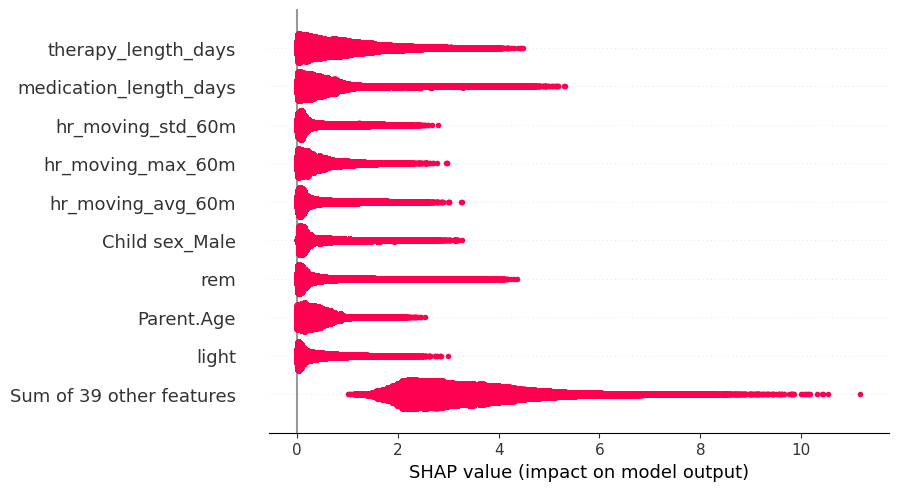

In [12]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

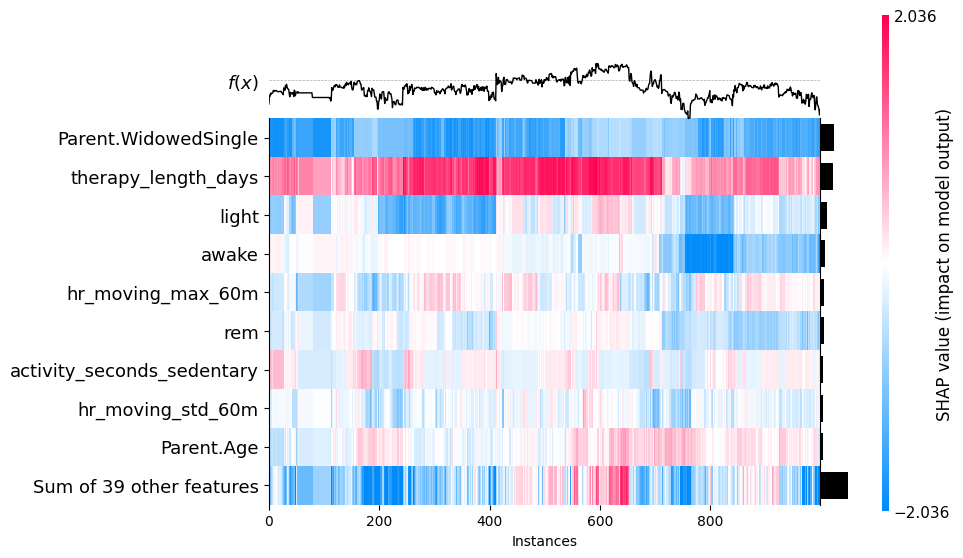

<Axes: xlabel='Instances'>

In [13]:
shap.plots.heatmap(shap_values[:1000])

In [14]:
y[y == 1]

787       1
788       1
805       1
806       1
858       1
         ..
467651    1
468994    1
468995    1
471007    1
471008    1
Name: tantrum_within_30m, Length: 1213, dtype: int64

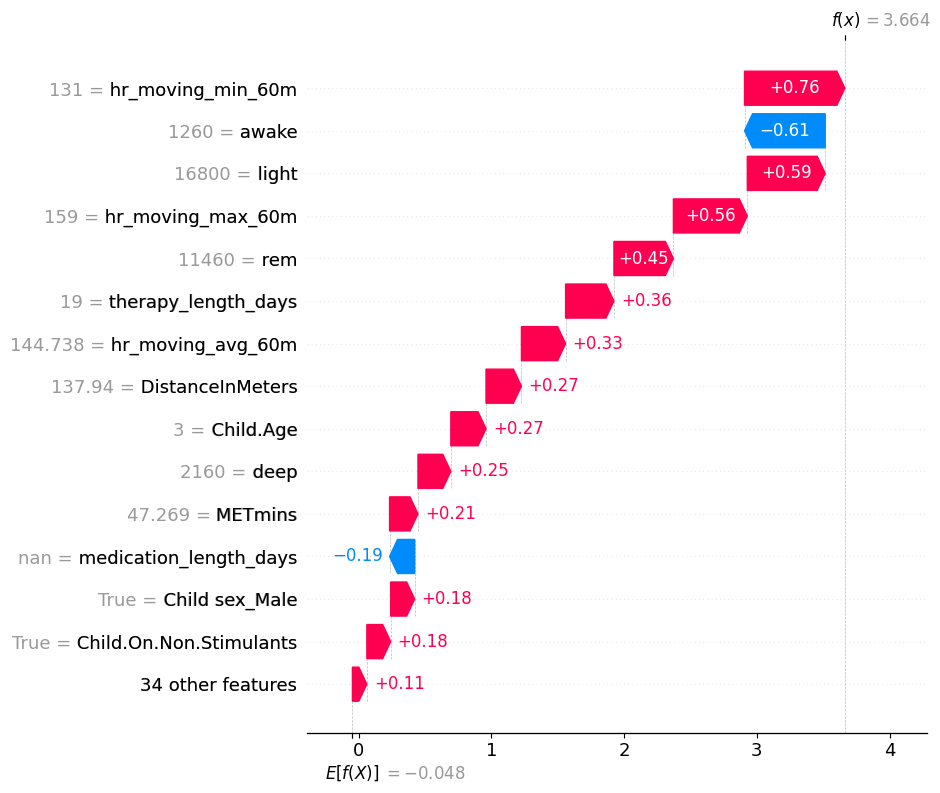

In [19]:
shap.plots.waterfall(shap_values[466567], max_display=15)